# CIFAR-10

CIFAR-10 dataset: http://www.cs.toronto.edu/~kriz/cifar.html

#### Cieľ zadania: Klasifikácia obrázku jednej z nasledujúcich tried:
• 0: airplane\
• 1: automobile\
• 2: bird\
• 3: cat\
• 4: deer\
• 5: dog\
• 6: frog\
• 7: horse\
• 8: ship\
• 9: truck

In [6]:
from matplotlib import pyplot
from keras.datasets import cifar10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add

In [7]:
def countValues(data):
    unique_vals, counts = np.unique(data, return_counts=True)

    for val, count in zip(unique_vals, counts):
        print("Class {}: {} records".format(val, count))

In [8]:
def dataNormalisation(data):
    return data.astype('float32') / 255.0

In [9]:
dataClass = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [10]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

print('Train dataset:\n X=%s\n y=%s\n' % (X_train.shape, y_train.shape))
print('Validation dataset:\n X=%s\n y=%s' % (X_val.shape, y_val.shape))

Train dataset:
 X=(50000, 32, 32, 3)
 y=(50000, 1)

Validation dataset:
 X=(10000, 32, 32, 3)
 y=(10000, 1)


In [11]:
countValues(y_train)

Class 0: 5000 records
Class 1: 5000 records
Class 2: 5000 records
Class 3: 5000 records
Class 4: 5000 records
Class 5: 5000 records
Class 6: 5000 records
Class 7: 5000 records
Class 8: 5000 records
Class 9: 5000 records


In [12]:
countValues(y_val)

Class 0: 1000 records
Class 1: 1000 records
Class 2: 1000 records
Class 3: 1000 records
Class 4: 1000 records
Class 5: 1000 records
Class 6: 1000 records
Class 7: 1000 records
Class 8: 1000 records
Class 9: 1000 records


Normalizacia dat do intervalu 0 - 1

In [13]:
X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

In [14]:
countValues(y_val)

Class 0: 497 records
Class 1: 482 records
Class 2: 507 records
Class 3: 504 records
Class 4: 500 records
Class 5: 511 records
Class 6: 494 records
Class 7: 507 records
Class 8: 494 records
Class 9: 504 records


In [15]:
countValues(y_test)

Class 0: 503 records
Class 1: 518 records
Class 2: 493 records
Class 3: 496 records
Class 4: 500 records
Class 5: 489 records
Class 6: 506 records
Class 7: 493 records
Class 8: 506 records
Class 9: 496 records


### Dáta:
• RGB obrázky v rozmeroch 32x32x3\
• obrázky rozdelené do 10 tried

Trénovacích vzoriek: 50000 - každá trieda má 5000 vzoriek\
Validačných vzoriek: 10000 - každá trieda má 1000 vzoriek\
&emsp;&emsp;&emsp;    • validačný dataset - 5000 vzoriek\
&emsp;&emsp;&emsp;    • testovací dataset - 5000 vzoriek

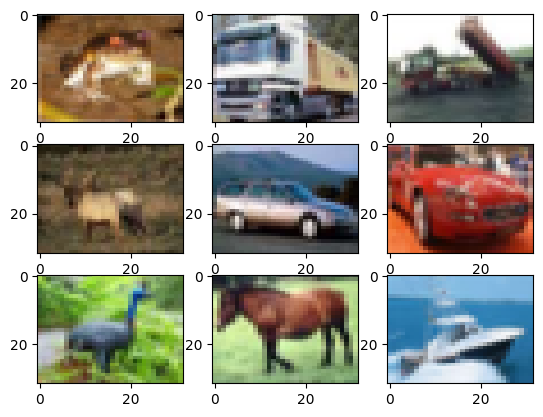

In [16]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(X_train[i], aspect='auto')
plt.show()

In [17]:
print('Class:')
for i in range(9):
    print(y_train[i], '-', dataClass[y_train[i][0]])

Class:
[6] - frog
[9] - truck
[9] - truck
[4] - deer
[1] - automobile
[1] - automobile
[2] - bird
[7] - horse
[8] - ship


In [18]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [19]:
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Pokus 1

In [65]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 50s 32ms/step - loss: 1.3674 - accuracy: 0.5123 - val_loss: 1.1300 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 51s 33ms/step - loss: 1.0005 - accuracy: 0.6489 - val_loss: 0.9819 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 53s 34ms/step - loss: 0.8310 - accuracy: 0.7103 - val_loss: 0.9115 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 55s 35ms/step - loss: 0.6839 - accuracy: 0.7608 - val_loss: 0.8773 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 5/5
157/157 [==============================] - 1s 6ms/step - loss: 0.8565 - accuracy: 0.7134


# Pokus 2

In [ ]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

In [67]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.8565401434898376
Test accuracy: 0.7134000062942505


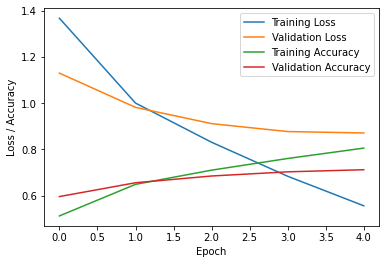

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus 3

In [50]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 106s 66ms/step - loss: 1.2960 - accuracy: 0.5545 - val_loss: 1.1985 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 103s 66ms/step - loss: 0.9230 - accuracy: 0.6755 - val_loss: 1.0633 - val_accuracy: 0.6334 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 104s 67ms/step - loss: 0.7500 - accuracy: 0.7370 - val_loss: 1.1400 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 119s 76ms/step - loss: 0.6072 - accuracy: 0.7884 - val_loss: 1.2403 - val_accuracy: 0.6376 - lr: 0.0010
Epoch 5/5
157/157 [==============================] - 2s 12ms/step - loss: 0.9663 - accuracy: 0.7004


In [66]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_49 (Flatten)        (None, 2304)              0         
                                                                 
 dense_78 (Dense)            (None, 512)             

In [51]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.9662764668464661
Test accuracy: 0.7003999948501587


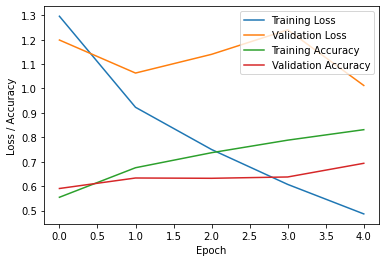

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus 4

In [23]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU', input_shape=(32, 32, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU'),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='LeakyReLU'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Conv2D(128, kernel_size=(5, 5), activation='LeakyReLU'),
    layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), activation='LeakyReLU'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(256, activation='LeakyReLU'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='LeakyReLU'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
  31/1563 [..............................] - ETA: 1:59 - loss: 2.7138 - accuracy: 0.1925

KeyboardInterrupt: 

In [107]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_284 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_285 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_168 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_286 (Conv2D)         (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_169 (Ba  (None, 13, 13, 64)     

In [108]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.7795038819313049
Test accuracy: 0.7218000292778015


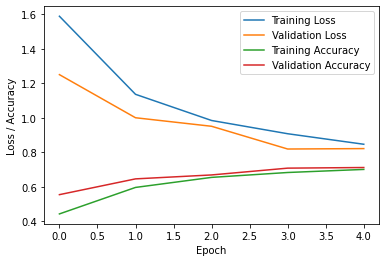

In [109]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus 5

In [21]:
def resnet_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='LeakyReLU', padding='same')(input_data)
    x = layers.Conv2D(filters, conv_size, activation='LeakyReLU', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('LeakyReLU')(x)
    return x

input_layer = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU')(input_layer)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU')(x)
x = layers.BatchNormalization()(x)

x = resnet_block(x, filters=32, conv_size=(3, 3))
x = resnet_block(x, filters=32, conv_size=(3, 3))

x = layers.Conv2D(64, kernel_size=(3, 3), activation='LeakyReLU')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = resnet_block(x, filters=64, conv_size=(5, 5))

x = layers.Conv2D(128, kernel_size=(5, 5), activation='LeakyReLU')(x)
x = layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), activation='LeakyReLU')(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='LeakyReLU')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='LeakyReLU')(x)
output_layer = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)


Epoch 1/5
  21/1563 [..............................] - ETA: 5:25 - loss: 2.9067 - accuracy: 0.1592

KeyboardInterrupt: 

In [102]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_257 (Conv2D)            (None, 30, 30, 32)   896         ['input_14[0][0]']               
                                                                                                  
 conv2d_258 (Conv2D)            (None, 28, 28, 32)   9248        ['conv2d_257[0][0]']             
                                                                                                  
 batch_normalization_153 (Batch  (None, 28, 28, 32)  128         ['conv2d_258[0][0]']             
 Normalization)                                                                             

In [68]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.7586472034454346
Test accuracy: 0.7319999933242798


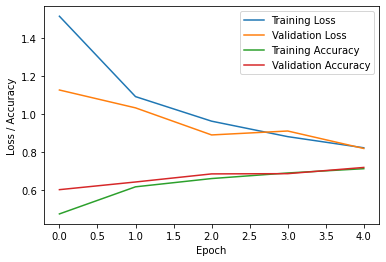

In [69]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 6

In [24]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
 229/1563 [===>..........................] - ETA: 17s - loss: 1.8698 - accuracy: 0.3145

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 7

In [25]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
 105/1563 [=>............................] - ETA: 35s - loss: 2.5734 - accuracy: 0.1557

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 8

In [26]:
import tensorflow as tf

# Define the residual block
def residual_block(inputs, filters, stride=1):
    shortcut = inputs

    # First convolutional layer with 3x3 filters and ReLU activation
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=stride, padding='same', activation='relu')(inputs)
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)
    # Second convolutional layer with 3x3 filters and ReLU activation
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    # Batch normalization layer
    x = tf.keras.layers.BatchNormalization()(x)

    # Add the shortcut to the residual block output and apply ReLU activation
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=stride, padding='valid', activation='relu')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x


# Define the model architecture with residual blocks
inputs = tf.keras.layers.Input(shape=(32, 32, 3))

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=64)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=128)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=256)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

                                                 
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)
                                                 
                                                 

Epoch 1/5
   6/1563 [..............................] - ETA: 3:37 - loss: 3.2941 - accuracy: 0.1615

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

  # pokus cislo 9

In [28]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential()

# Add convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))

# Add dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
  17/1563 [..............................] - ETA: 2:17 - loss: 3.3886 - accuracy: 0.1250

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 10

In [32]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)


Epoch 1/5
  43/1563 [..............................] - ETA: 6:28 - loss: 2.9836 - accuracy: 0.1265

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 11

In [35]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.00005)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop])

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.4926 - accuracy: 0.4783 - val_loss: 1.4591 - val_accuracy: 0.4638 - lr: 0.0010
Epoch 2/5
1159/1563 [=====================>........] - ETA: 6s - loss: 1.1265 - accuracy: 0.5974

KeyboardInterrupt: 

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

#### Augmentovany a normalizovany dataset

In [151]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

Augmentacia dat, zvysenie poctu obrazkov o dvojnasobok

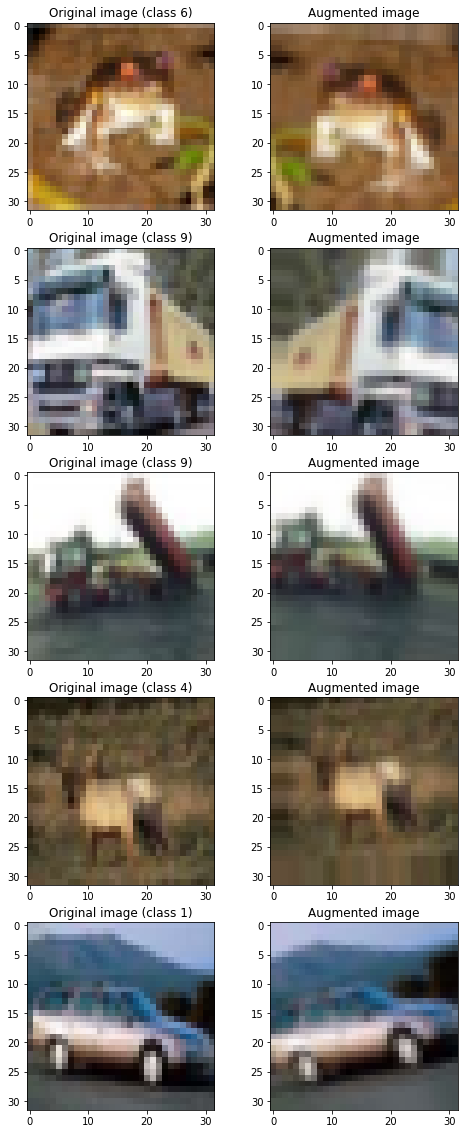

In [152]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

# Generate augmented images and labels
augmented_images = []
augmented_labels = []
for i in range(X_train.shape[0]):
    # Generate augmented image
    augmented_image = datagen.random_transform(X_train[i])
    # Append augmented image to list of augmented images
    augmented_images.append(augmented_image)
    # Append corresponding label to list of augmented labels
    augmented_labels.append(y_train[i])

# Convert the list of augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original images and labels with augmented images and labels
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

# Plot the original and augmented images
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
for i in range(5):
    # Plot the original image
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title(f"Original image (class {y_train[i][0]})")

    # Plot the augmented image
    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Augmented image")
plt.show()

In [153]:
print(X_train.shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 1)


In [ ]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [154]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/5
3125/3125 [==============================] - 114s 36ms/step - loss: 1.3021 - accuracy: 0.5340 - val_loss: 1.0408 - val_accuracy: 0.6410
Epoch 2/5
3125/3125 [==============================] - 126s 40ms/step - loss: 0.9542 - accuracy: 0.6642 - val_loss: 0.9232 - val_accuracy: 0.6842
Epoch 3/5
3125/3125 [==============================] - 114s 36ms/step - loss: 0.7812 - accuracy: 0.7276 - val_loss: 0.8594 - val_accuracy: 0.7080
Epoch 4/5
3125/3125 [==============================] - 111s 35ms/step - loss: 0.6453 - accuracy: 0.7753 - val_loss: 0.8032 - val_accuracy: 0.7340
Epoch 5/5
157/157 [==============================] - 1s 7ms/step - loss: 0.8494 - accuracy: 0.7406


In [155]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.8494152426719666
Test accuracy: 0.7405999898910522


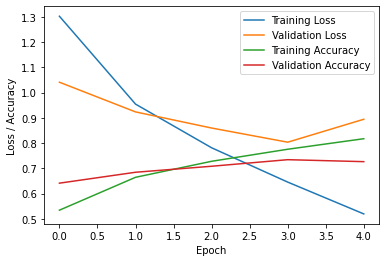

In [156]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()